In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
from fastai import *
from fastai.text import *

# Python code Examples (testing out tokenizer)

## Data

### Reading the texts

In [4]:
PATH = Path('/home/farzin/rnn_python_code/wiki103_from_download')

In [5]:
all_texts_df = pd.read_csv('/home/farzin/fast_ai/fastai_v1/courses/dl2/imdb_scripts/data/wiki/en/train.csv',sep='%$#')

/home/farzin/anaconda3/envs/fastaiv1_dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [6]:
all_texts = all_texts_df.values.squeeze()

In [7]:
#all_texts = np.concatenate([train_texts,valid_texts])
idx = np.random.permutation(len(all_texts))
cut = int(0.1 * len(idx))
train_df = pd.DataFrame({'text':all_texts[idx[cut:]], 'labels':[0] * (len(all_texts)-cut)}, columns=['labels','text'])
valid_df = pd.DataFrame({'text':all_texts[idx[:cut]], 'labels':[0] * cut}, columns=['labels','text'])

In [8]:
## Does any of this apply to Python code?  What do I need to include here that is relevant?

#export
def sub_br(t:str) -> str:
    "Replaces the <br /> by \n"
    re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
    return re_br.sub("\n", t)

def spec_add_spaces(t:str) -> str:
    "Add spaces between special characters"
    return re.sub(r'([/#])', r' \1 ', t)

def rm_useless_spaces(t:str) -> str:
    "Remove multiple spaces"
    return re.sub(' {2,}', ' ', t)

def replace_rep(t:str) -> str:
    "Replace repetitions at the character level"
    def _replace_rep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_REP} {len(cc)+1} {c} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)
    
def replace_wrep(t:str) -> str:
    "Replace word repetitions"
    def _replace_wrep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_WREP} {len(cc.split())+1} {c} '
    re_wrep = re.compile(r'(\b\w+\W+)(\1{3,})')
    return re_wrep.sub(_replace_wrep, t)

def deal_caps(t:str) -> str:
    "Replace words in all caps"
    res = []
    for s in re.findall(r'\w+|\W+', t):
        res += ([f' {TK_UP} ',s.lower()] if (s.isupper() and (len(s)>2)) else [s.lower()])
    return ''.join(res)

def fixup(x:str) -> str:
    "List of replacements from html strings"
    re1 = re.compile(r'  +')
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>',UNK).replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

default_rules = [fixup, replace_rep, replace_wrep, deal_caps, spec_add_spaces, rm_useless_spaces, sub_br]
default_spec_tok = [BOS, FLD, UNK, PAD]

In [9]:
tokenizer = Tokenizer(pre_rules=default_rules, special_cases=[BOS, FLD, 'xxunk', 'xxpad'], n_cpus=4,bwd_toks=True)

In [13]:
tokenizer

Tokenizer SpacyTokenizer in en with the following rules:
 - fixup
 - replace_rep
 - replace_wrep
 - deal_caps
 - spec_add_spaces
 - rm_useless_spaces
 - sub_br
 - replace_all_caps
 - deal_caps

In [11]:
train_df = train_df.dropna()
valid_df = valid_df.dropna()

In [12]:
max_vocab = 60000 #can we make this the full possible vocab at 260k?
batch_size = 32

keyword_args = {'max_vocab':max_vocab,'bs':batch_size}
data = TextLMDataBunch.from_df(PATH, train_df, valid_df, tokenizer=tokenizer,
                               text_cols='text', label_cols='labels',**keyword_args)

In [14]:
train_df.iloc[0,1]

'BMW used Nikasil- an aluminium, nickel, and silicon alloy- to line the cylinders of the M60 engines. In fuels with high sulfur content (such as used fuels sold in the United States, UK and South America), the sulfur damages the Nikasil bore lining, causing the engine to lose compression.'

In [23]:
## forward

In [14]:
data.train_ds.x[0].data

array([  2,  33, 121,  18, ..., 158,  24, 364,  10])

In [15]:
data.train_ds.x[0].text

'xxbos his name is an xxunk form of the persian name " " xxunk " " , xxunk under the influence of his xxunk persian xxunk . he xxunk his brother \' xxunk xxup iii ibn al - mundhir ( r. xxunk ) . not much is known of his xxunk except that he xxunk a heavy xxunk at the hands of the rival xxunk - sponsored xxunk xxunk under al - mundhir xxup iii ibn al - xxunk in xxunk . after his death , the xxunk were ruled by a persian governor for a year , until xxunk \' brother al - mundhir iv ibn al - mundhir ( r. xxunk ) was named as king .'

In [24]:
## BOS + backward tokens

In [15]:
data.train_ds.x[0].data

array([   2,   10, 8869, 3806, ...,    0,   89, 9029,    5])

In [16]:
data.train_ds.x[0].text

'xxbos . compression lose to engine the causing , lining bore xxunk the damages sulfur the , ) america south and uk , states united the in sold fuels used as such ( content sulfur high with fuels in . engines m60 xxup the of cylinders the line to xxunk silicon and , nickel , aluminium an xxunk used bmw xxup'

In [17]:
len(data.vocab.itos)

60004

In [20]:
data.save('tmp_bwd')

In [21]:
!ls -lhart {PATH}/tmp_bwd/

total 1.2G
drwxrwxr-x 6 farzin farzin 4.0K Jan 23 10:22 ..
-rw-rw-r-- 1 farzin farzin 999K Jan 23 10:22 itos.pkl
-rw-rw-r-- 1 farzin farzin 1.1G Jan 23 10:23 train_ids.npy
-rw-rw-r-- 1 farzin farzin  20M Jan 23 10:23 train_lbl.npy
-rw-rw-r-- 1 farzin farzin 119M Jan 23 10:23 valid_ids.npy
-rw-rw-r-- 1 farzin farzin 2.2M Jan 23 10:23 valid_lbl.npy
-rw-rw-r-- 1 farzin farzin    2 Jan 23 10:23 classes.txt
drwxrwxr-x 2 farzin farzin 4.0K Jan 23 10:23 .


In [19]:
!ls -lhart {PATH}/tmp/

total 141M
-rw-rw-r-- 1 farzin farzin  20M Jan 17 13:23 train_lbl.npy
-rw-rw-r-- 1 farzin farzin 118M Jan 17 13:24 valid_ids.npy
-rw-rw-r-- 1 farzin farzin 2.2M Jan 17 13:24 valid_lbl.npy
-rw-rw-r-- 1 farzin farzin    2 Jan 17 13:24 classes.txt
drwxrwxr-x 2 farzin farzin 4.0K Jan 17 13:24 .
drwxrwxr-x 5 farzin farzin 4.0K Jan 17 13:37 ..
-rw-rw-r-- 1 farzin farzin 999K Jan 23 10:21 itos.pkl
-rw-rw-r-- 1 farzin farzin  128 Jan 23 10:22 train_ids.npy


In [22]:
bptt = 140
emb_sz,nh,nl = 400,1111,4

learn = language_model_learner(data,bptt,emb_sz,nh,nl,drop_mult=0.5,qrnn=True)
learn.unfreeze()
learn.model

SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(60004, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60004, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=800, out_features=3333, bias=True)
        )
      )
      (1): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1111, out_features=3333, bias=True)
        )
      )
      (2): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1111, out_features=3333, bias=True)
        )
      )
      (3): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1111, out_features=1200, bias=True)
        )
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
      (3): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Li

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


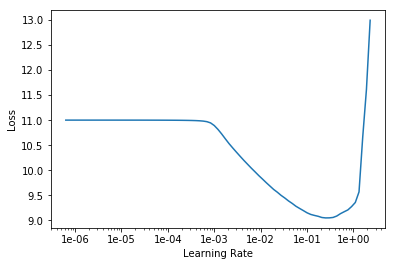

In [23]:
lr_find(learn)
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7), wd=0.03, pct_start=0.25)

epoch,train_loss,valid_loss,accuracy
1,4.599080,4.494251,0.305755
2,4.744382,4.640317,0.291409
3,4.770506,4.658196,0.289946
4,4.748968,4.617092,0.293294
5,4.677838,4.555842,0.297624
6,4.597003,4.466496,0.306344
7,4.471542,4.359515,0.315975
8,4.368707,4.241202,0.327871
9,4.281856,4.142269,0.339645
10,4.265164,4.105095,0.344774


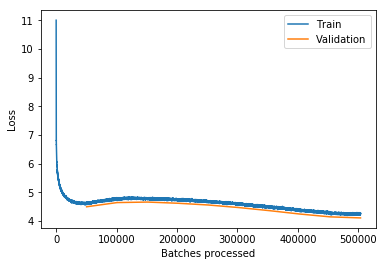

In [25]:
learn.recorder.plot_losses()

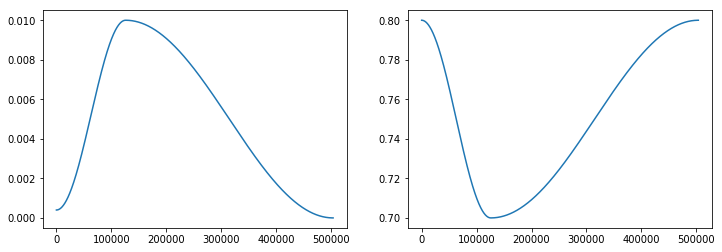

In [26]:
learn.recorder.plot_lr(show_moms=True)

In [33]:
np.exp(4.08)

59.14546984988227

In [27]:
data.show_batch()

idx,text
0,"xxbos . entrepreneur xxbos . leadership xxbos bridge covered walker xxunk "" xxbos > "" "" 1 "" "" = midi "" "" 1 "" "" = xxunk score < xxbos "" xxbos utilities xxbos : conditions following the with associated is it xxbos . instead destruction and mayhem cause to manages generally he , unfortunately ; others helping is he believes cockroach the xxunk his of most in xxbos"
1,"both as characterised been has he . structure song experimental an have occasionally they and , melodies unconventional feature , xxunk often are compositions his . production the in section rhythm subdued a by backed is and , himself ocean by performed often , keyboard electronic the includes generally music 's ocean . style in idiosyncratic as writers music by characterized been has music 's ocean xxbos . hyderabad from"
2,", lock first the in resulted 1809 in scheme modified a . cut lock ambitious an with 1805 in was lock a for plan first the . effects tidal minor had locally river the downstream xxunk much caused which ) 1831 - xxunk ( bridge london old of period the in , sunbury the in flats and shoals many of because times medieval since place in were locally weirs such"
3,"provide to order in , estates earning and revenues with endowed church a is church collegiate a . myra of nicholas and , xxunk of erasmus , tarsus of paul , peter simon , cross holy the , nazareth of ) xxunk to dedicated "" "" nicolai . st und xxunk . st , pauli und petri . st , xxunk xxunk des , xxunk xxunk xxunk xxunk zu xxunk"
4,"personal exercise to authorized was ohio where , "" "" patterson v. . inc , xxunk "" "" in defendant the of those with actions and website 's king contrasted court the , specifically . state particular one any at directed purposefully was that act an not was website informational an of creation mere the that and , offered york new that benefits any of himself avail purposefully not did"


In [31]:
learn.save("wiki103_raw_articles_spacy_BWD_20190123")
learn.save_encoder('wiki103_spacy_enc_BWD')